In [20]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.decision_sets.pruning import *
from intercluster.experiments import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [11]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(5), cmap(6)]
cmap_subset = ListedColormap(subset_colors)

subset_colors2 = ['red', cmap(5), cmap(6)]
cmap_subset2 = ListedColormap(subset_colors2)

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (doing so, however, will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

## Example Setting

In [12]:
n = 1000
k = 2
data, labels = datasets.make_moons(n_samples = n, noise = 0.05, random_state = seed)

#data, labels = datasets.make_circles(n_samples=n, factor=0.5, noise=0.05, random_state=seed)

Text(0, 0.5, 'y')

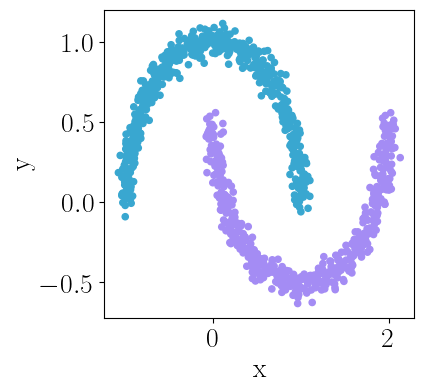

In [13]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

### DBSCAN Reference Clustering

In [14]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(data)

dbscan_labels = labels_format(dbscan.labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k)

Text(0, 0.5, 'y')

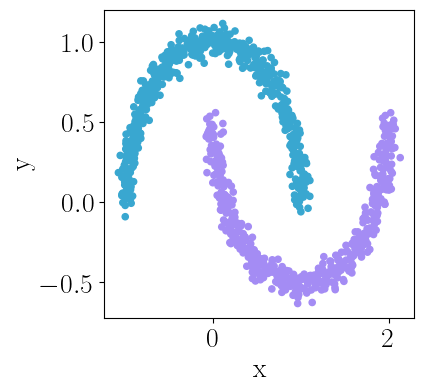

In [15]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = dbscan.labels_, cmap = cmap_subset, s = 20)

ax.set_xlabel('x')
ax.set_ylabel('y')

### Basic Decision Tree

In [16]:
tree = SklearnTree(max_leaf_nodes = 6)
tree.fit(data, dbscan_labels)
y_tree = flatten_labels(tree.predict(data))

Text(0, 0.5, 'y')

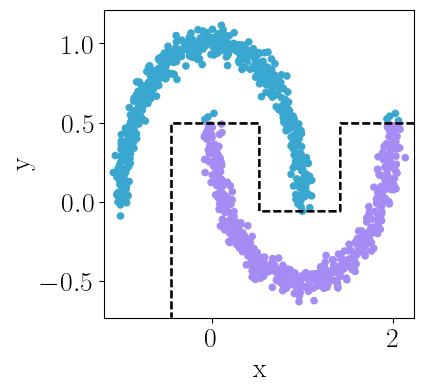

In [17]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = y_tree, cmap = cmap_subset, s = 20)
plot_decision_boundaries(tree, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

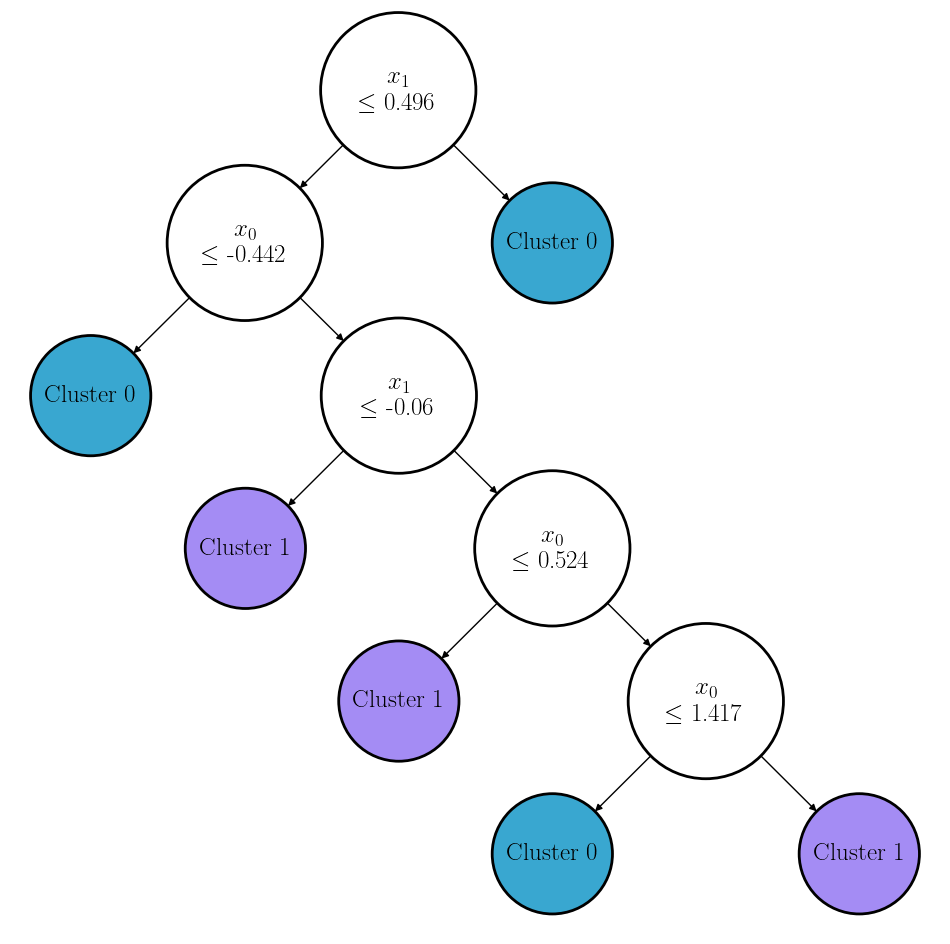

In [18]:
draw_tree(tree.root, cmap = cmap_subset)

### Mistake Minimization Tree

Next, we show an implementation for the what we call the Explanation Tree algorithm, 
designed by Bandyapadhyay et al. in their work "How to find a good explanation for clustering?"
The algorithm works by removing outliers during the training process, aiming to find a minimal 
number of points to remove so that the resulting tree exactly replicates KMeans on everything 
that remains.

In [21]:
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
exp_labels = exp_tree.predict(data, remove_outliers = True)

# After fitting, we can observe its outliers attribute to see what was removed.
outliers = list(exp_tree.outliers)
non_outliers = [i for i in range(len(data)) if i not in outliers]
exp_label_array = flatten_labels([exp_labels[l] for l in non_outliers])

Text(0, 0.5, 'y')

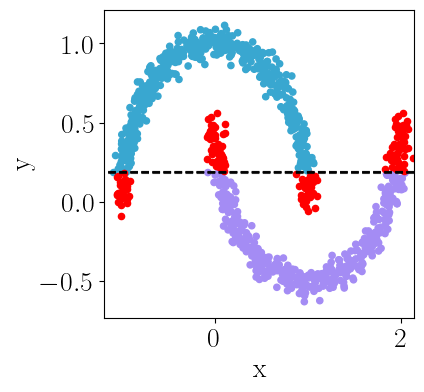

In [22]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[non_outliers,0], data[non_outliers,1], c = exp_label_array, cmap = cmap_subset, s = 20)

# Removed outlier points are displayed in red!
ax.scatter(data[outliers,0], data[outliers,1], c = 'red', s = 20)

plot_decision_boundaries(exp_tree, data[non_outliers,:], ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

### Decision Forest

In [23]:
np.random.seed(918713)

In [24]:
# Our implementation allows for certain subsets of features to be paired together, 
# meaning they will always be used together in the trees.
feature_pairings = [[0, 1]]

# Likewise we also specify a maximum depth for the trees. 
forest_tree_params = {
    'max_depth' : 4
}

# The following trains a random forest of 100 trees on random 75% portions of the data.
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)

data_labels = labels_format(dbscan.labels_)
forest.fit(data, data_labels)

In [25]:
# Now we have a trained forest with a lot of rules, so we'll need to prune it 
# with a distorted greedy selection process. 

# We first give a kmeans cost objective to the grid search algorithm. This is used to 
# break ties if multiple solutions exist. 
prune_objective = CoverageObjective()

# We then tell the forest to prune, and give 3 rules which cover 90% of the data. 
# We also specify a search range for lambda values.
forest.prune(
    n_rules = 6,
    frac_cover = 0.9,
    n_clusters = k,
    X = data, 
    y = labels_format(dbscan.labels_),
    objective = prune_objective,
    lambda_search_range = np.linspace(0,5,51)
    
)

# The resulting set of predicted labels may be obtained with the pruned predict method. 
prune_predictions = forest.pruned_predict(data, rule_labels = False)

In [26]:
# We'll pull the pruned decision set out of the forest.
pruned_decision_set = [forest.decision_set[i] for i in forest.pruned_indices]
pruned_decision_set_labels = [forest.decision_set_labels[i] for i in forest.pruned_indices]

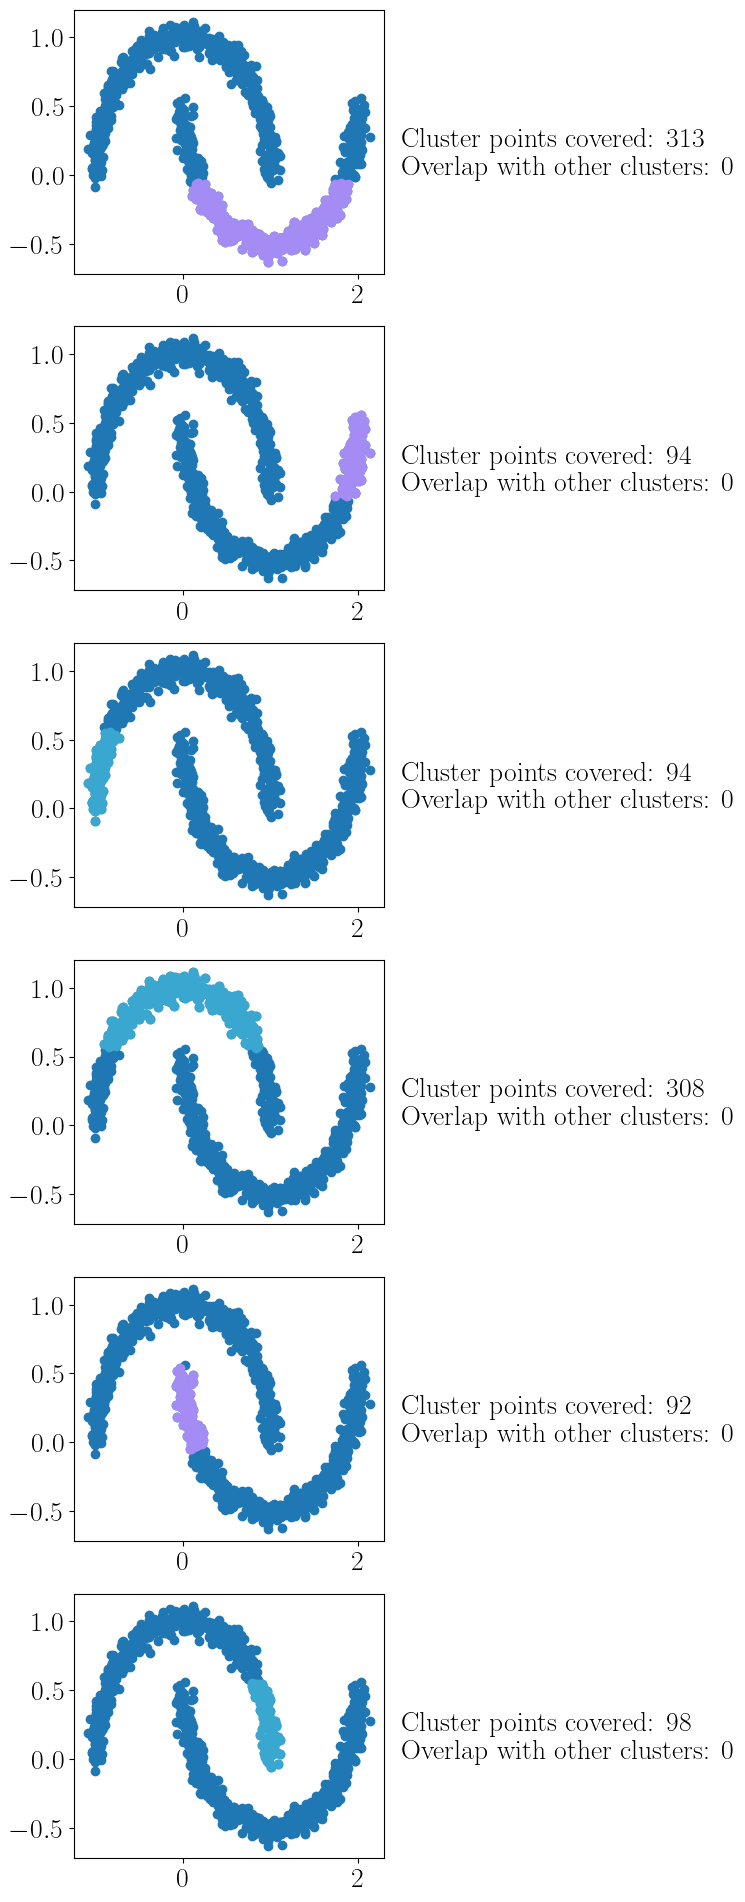

In [27]:
# Then visualize what's covered by each of the rules:
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(pruned_decision_set):
    r_label = list(forest.decision_set_labels[forest.pruned_indices[i]])[0]
    indices = satisfies_conditions(data, condition_list)
    points_covered = np.sum(dbscan.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(dbscan.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap_subset(list(pruned_decision_set_labels[i])[0]))
        ax[i].text(x = 2.5, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap_subset(list(pruned_decision_set_labels[i])[0]))
        ax.text(x = 2.5, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

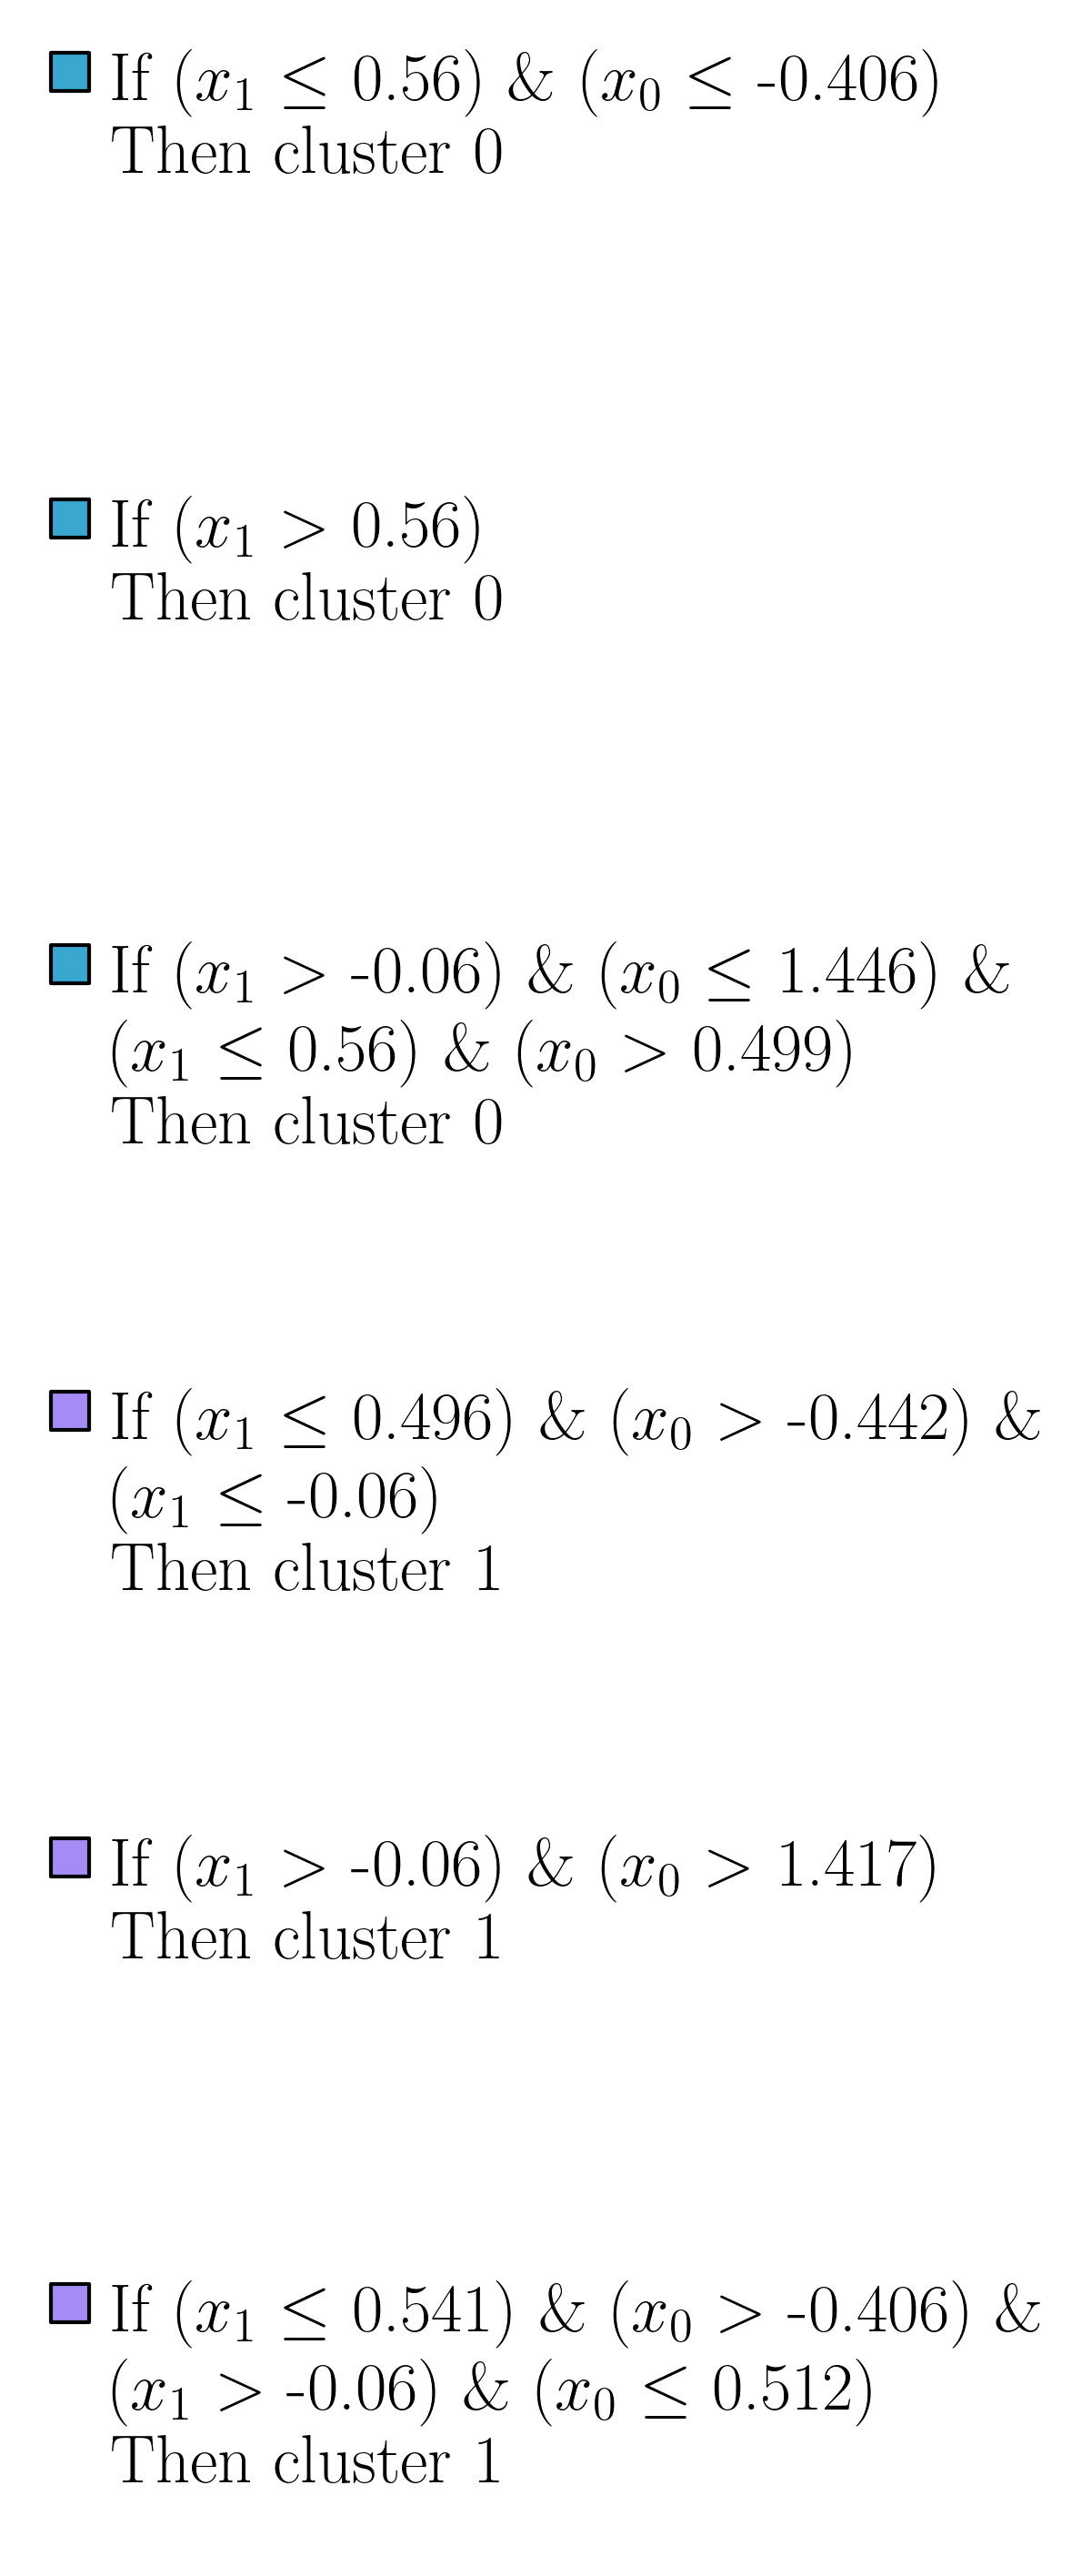

In [28]:
# Finally, we plot the pruned set of rules.
pruned_set = [forest.decision_set[i] for i in forest.pruned_indices]
pruned_rule_labels = [forest.decision_set_labels[i] for i in forest.pruned_indices]
plot_decision_set(
    decision_set = pruned_set,
    rule_labels = pruned_rule_labels,
    cmap = cmap_subset,
)

### Point Set

In [29]:
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.25)
point_set.fit(data, dbscan_labels)

In [30]:
# Now we have a trained forest with a lot of rules, so we'll need to prune it 
# with a distorted greedy selection process. 

# We first give a kmeans cost objective to the grid search algorithm. This is used to 
# break ties if multiple solutions exist. 
prune_objective = CoverageObjective()

# We then tell the forest to prune, and give 3 rules which cover 90% of the data. 
# We also specify a search range for lambda values.
point_set.prune(
    n_rules = 6,
    frac_cover = 0,
    n_clusters = k,
    X = data, 
    y = dbscan_labels,
    objective = prune_objective,
    lambda_search_range = [0.1]
    
)

# The resulting set of predicted labels may be obtained with the pruned predict method. 
prune_predictions = point_set.pruned_predict(data, rule_labels = False)

In [31]:
# We'll pull the pruned decision set out of the forest.
pruned_decision_set = [point_set.decision_set[i] for i in point_set.pruned_indices]
pruned_decision_set_labels = [point_set.decision_set_labels[i] for i in point_set.pruned_indices]

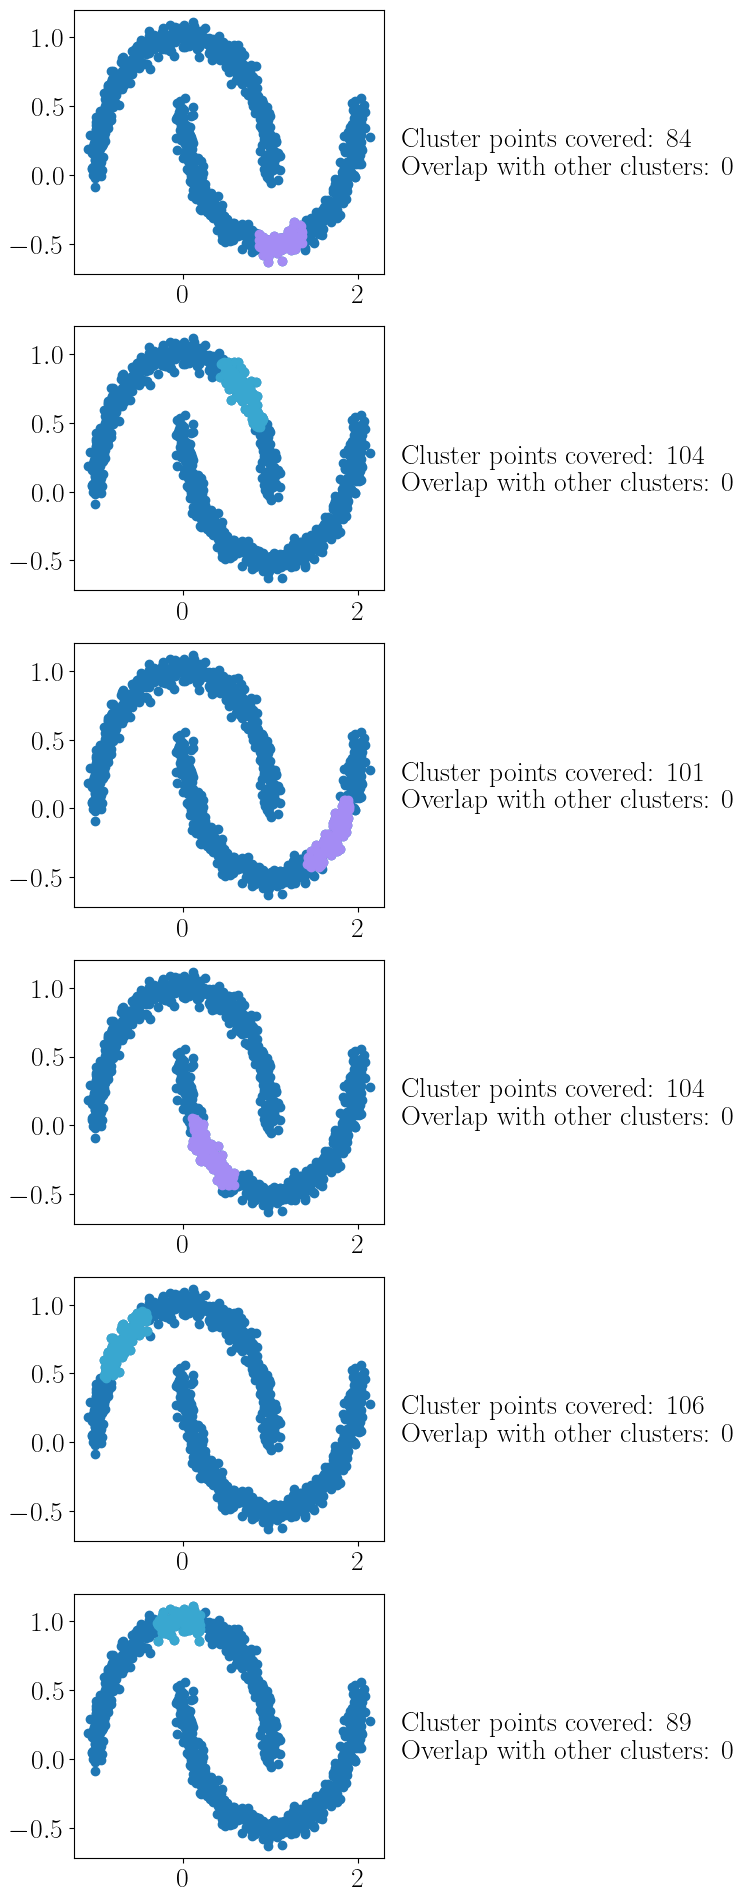

In [32]:
# Then visualize what's covered by each of the rules:
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(pruned_decision_set):
    r_label = list(point_set.decision_set_labels[point_set.pruned_indices[i]])[0]
    indices = satisfies_conditions(data, condition_list)
    points_covered = np.sum(dbscan.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(dbscan.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap_subset(list(pruned_decision_set_labels[i])[0]))
        ax[i].text(x = 2.5, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap_subset(list(pruned_decision_set_labels[i])[0]))
        ax.text(x = 2.5, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

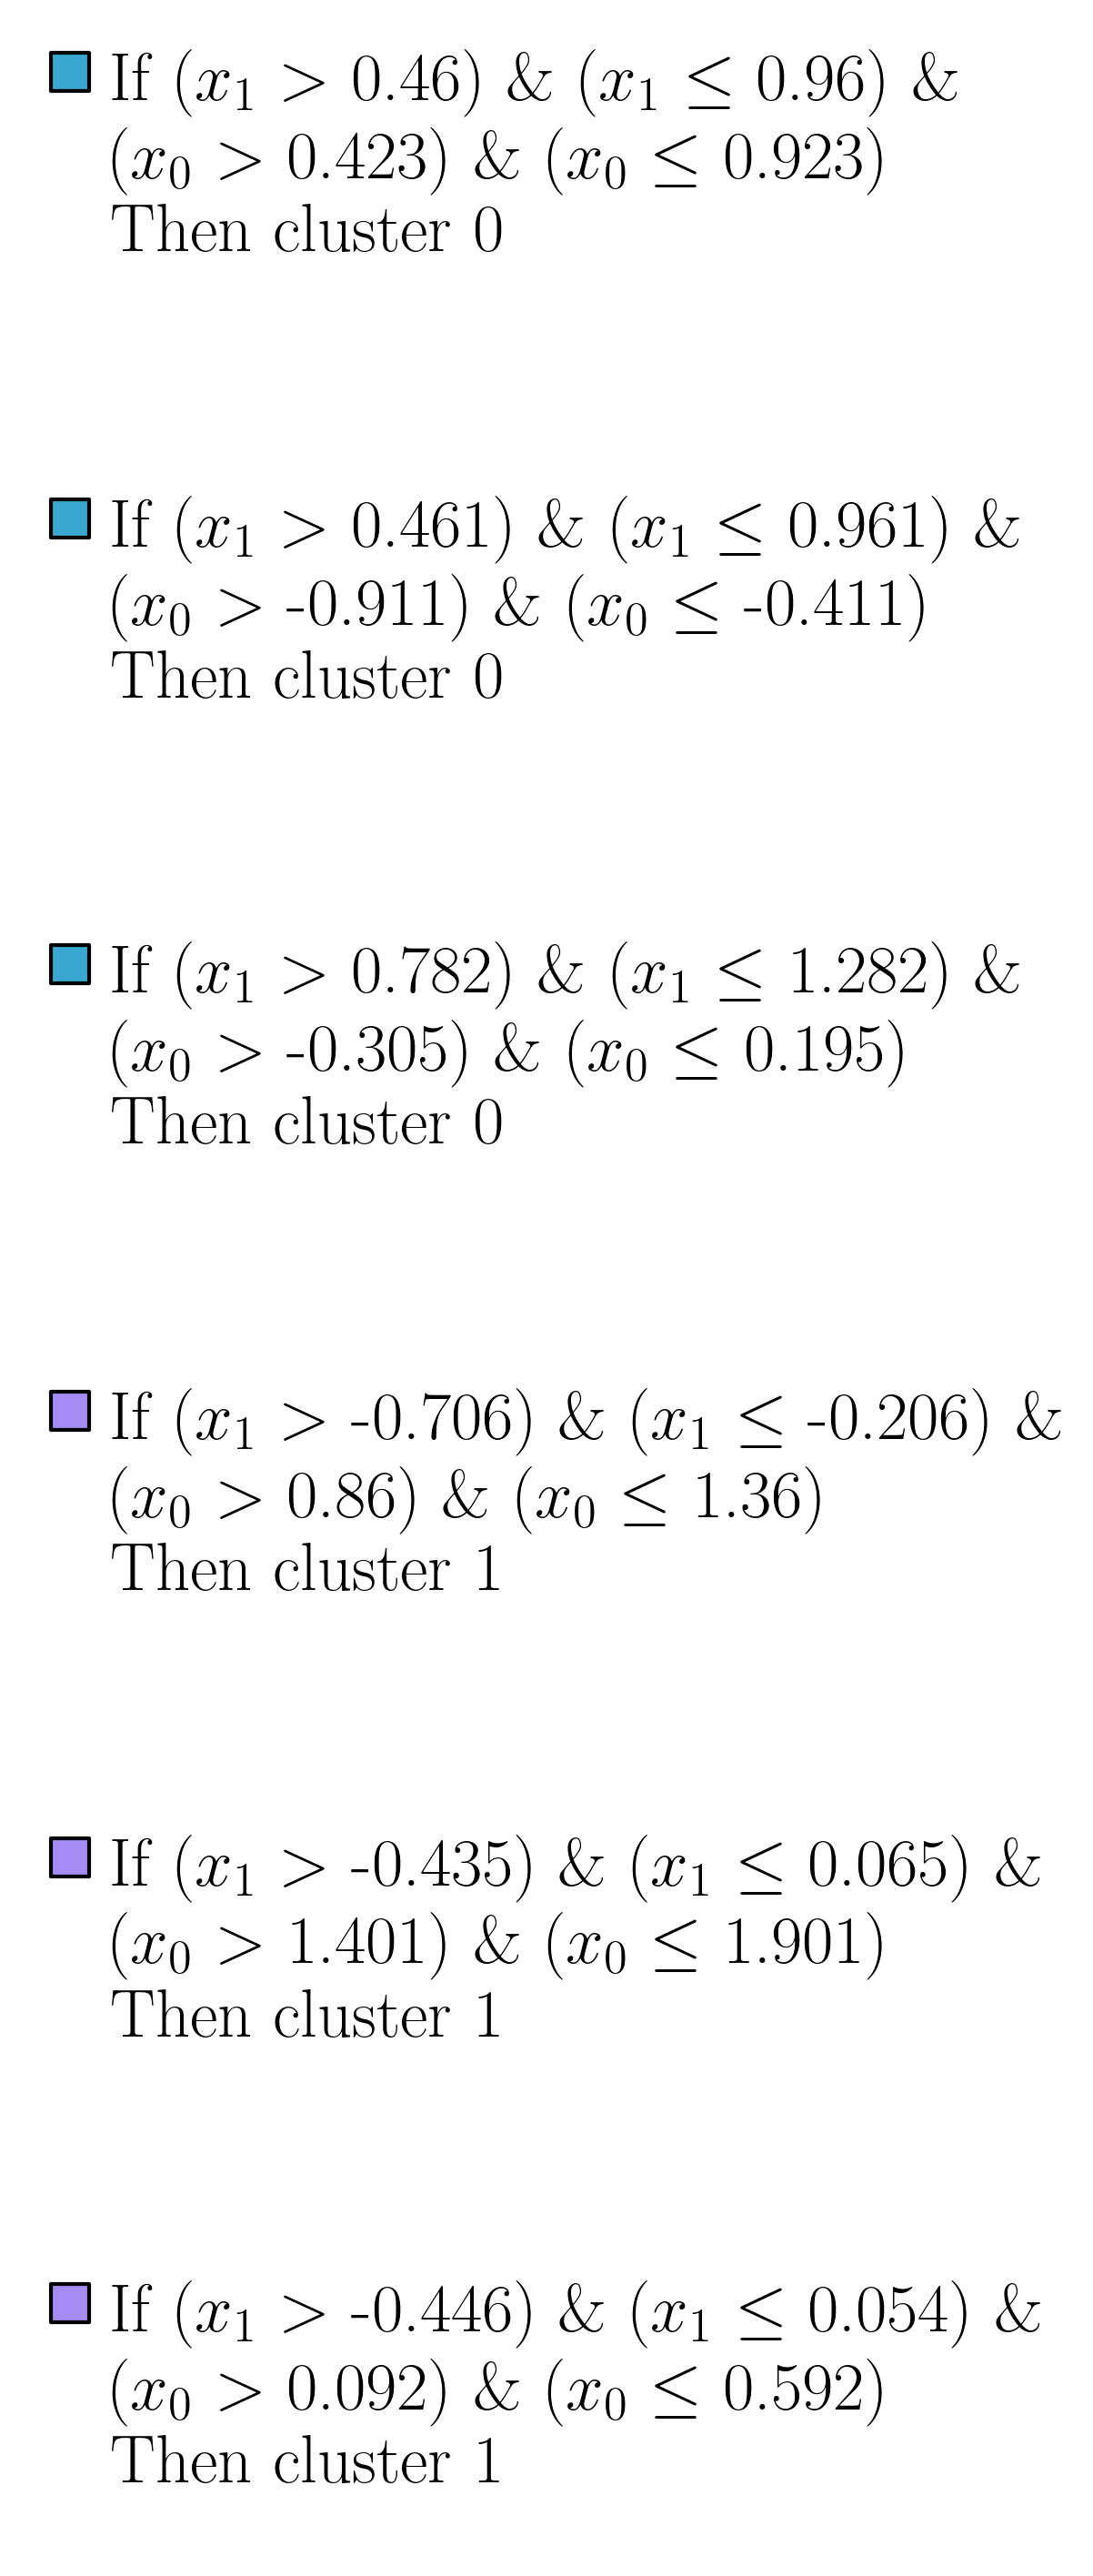

In [25]:
# Finally, we plot the pruned set of rules.
pruned_set = [point_set.decision_set[i] for i in point_set.pruned_indices]
pruned_rule_labels = [point_set.decision_set_labels[i] for i in point_set.pruned_indices]
plot_decision_set(
    decision_set = pruned_set,
    rule_labels = pruned_rule_labels,
    cmap = cmap_subset,
)

### Evaluation

In [26]:
def coverage_mistake_objective(
    X,
    y,
    decision_set,
    lambd : float = 1
):
    if not can_flatten(y):
        raise ValueError("Each data point must have exactly one label.")
    y_ = flatten_labels(y)
    k = len(np.unique(y_))

    if decision_set.pruned_indices is None:
        raise ValueError("The decision set has not been pruned")

    selected = decision_set.pruned_indices
    data_to_rules_assignment = decision_set.get_pruned_data_to_rules_assignment(X)
    rules_to_clusters_assignment = decision_set.get_pruned_rules_to_clusters_assignment(n_labels = k)
    data_to_clusters_assignment = (data_to_rules_assignment @ rules_to_clusters_assignment).astype(bool)
                
    cover = coverage(data_to_clusters_assignment, percentage = False)
    mistakes = 0
    for i in range(k):
        cluster_rules = np.where(rules_to_clusters_assignment[:,i])[0]
        for rule in cluster_rules:
            rule_points = np.where(data_to_rules_assignment[:,rule])[0]
            for point in rule_points:
                if y_[point] != i:
                    mistakes += 1
                    
    return cover - lambd * mistakes
        

In [27]:
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)
prune_objective = CoverageObjective()

decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))
explanation_tree_removals = len(exp_tree.outliers)

In [33]:
# With changing lambda value:
lambda_range = np.linspace(0,2,21)
max_rules = 5

lambda_evals = np.zeros(len(lambda_range))
forest_lambda_evals = np.zeros(len(lambda_range))
decision_tree_lambda_evals = np.zeros(len(lambda_range))
explanation_tree_lambda_evals = np.zeros(len(lambda_range))

# Decision Tree
tree = SklearnTree(max_leaf_nodes = max_rules)
tree.fit(data, dbscan_labels)
y_tree = flatten_labels(tree.predict(data))
decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))

# Explanation Tree
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
explanation_tree_removals = len(exp_tree.outliers)

# Decision Forest 
feature_pairings = [[0, 1]]
forest_tree_params = {
    'max_depth' : 4
}
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)
forest.fit(data, dbscan_labels)

# Point Set
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)

prune_objective = CoverageObjective()
for i,l in enumerate(lambda_range):
    point_set.prune(
        n_rules = max_rules,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = dbscan_labels,
        objective = prune_objective,
        lambda_search_range = [l]        
    )
    forest.prune(
        n_rules = max_rules,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = labels_format(dbscan.labels_),
        objective = prune_objective,
        lambda_search_range = [l] 
        
    )
    lambda_evals[i] = coverage_mistake_objective(data, dbscan_labels, point_set, lambd = l)
    forest_lambda_evals[i] = coverage_mistake_objective(data, dbscan_labels, forest, lambd = l)
    if l < 1:
        decision_tree_lambda_evals[i] = len(data) - l * decision_tree_mistakes
    else:
        decision_tree_lambda_evals[i] = len(data) - decision_tree_mistakes
    explanation_tree_lambda_evals[i] = (len(data) - explanation_tree_removals)

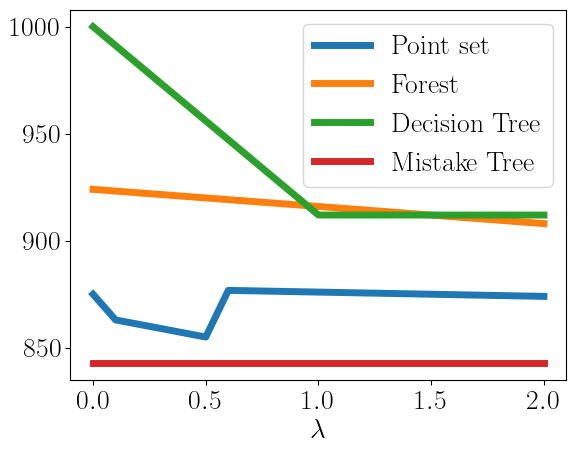

In [34]:
fix, ax = plt.subplots()
ax.plot(lambda_range, lambda_evals, linewidth = 5, label = 'Point set')
ax.plot(lambda_range, forest_lambda_evals, linewidth = 5, label = 'Forest')
ax.plot(lambda_range, decision_tree_lambda_evals, linewidth = 5, label = 'Decision Tree')
ax.plot(lambda_range, explanation_tree_lambda_evals, linewidth = 5, label = 'Mistake Tree')
ax.set_xlabel(r'$\lambda$')
plt.legend()

In [30]:
# With changing number of rules:
rule_range = np.arange(2,10)
lambd = 1

rule_evals = np.zeros(len(rule_range))
forest_rule_evals = np.zeros(len(rule_range))
decision_tree_rule_evals = np.zeros(len(rule_range))
explanation_tree_rule_evals = np.zeros(len(rule_range))

# Explanation Tree
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
explanation_tree_removals = len(exp_tree.outliers)

# Decision Forest 
feature_pairings = [[0, 1]]
forest_tree_params = {
    'max_depth' : 4
}
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)
forest.fit(data, dbscan_labels)

# Point Set
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)

prune_objective = CoverageObjective()
for i,r in enumerate(rule_range):
    # Decision Tree
    tree = SklearnTree(max_leaf_nodes = r)
    tree.fit(data, dbscan_labels)
    y_tree = flatten_labels(tree.predict(data))
    decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))

    
    point_set.prune(
        n_rules = r,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = dbscan_labels,
        objective = prune_objective,
        lambda_search_range = [lambd]        
    )
    
    forest.prune(
        n_rules = r,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = labels_format(dbscan.labels_),
        objective = prune_objective,
        lambda_search_range = [lambd] 
        
    )
    
    rule_evals[i] = coverage_mistake_objective(data, dbscan_labels, point_set, lambd = lambd)
    forest_rule_evals[i] = coverage_mistake_objective(data, dbscan_labels, forest, lambd = lambd)
    decision_tree_rule_evals[i] = len(data) - l * decision_tree_mistakes
    explanation_tree_rule_evals[i] = (len(data) - explanation_tree_removals)

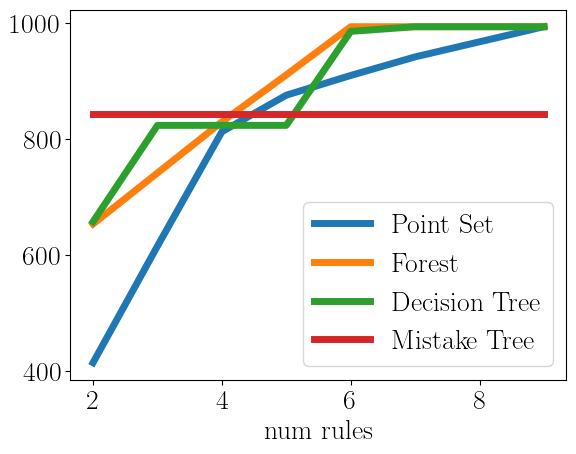

In [31]:
fix, ax = plt.subplots()
ax.plot(rule_range, rule_evals, linewidth = 5, label = 'Point Set')
ax.plot(rule_range, forest_rule_evals, linewidth = 5, label = 'Forest')
ax.plot(rule_range, decision_tree_rule_evals, linewidth = 5, label = 'Decision Tree')
ax.plot(rule_range, explanation_tree_rule_evals, linewidth = 5, label = 'Mistake Tree')
ax.set_xlabel('num rules')
plt.legend()